# HEX algorithm **Kopuru Vespa Velutina Competition**

**XGBoost model**

Purpose: Predict the number of Nests in each of Biscay's 112 municipalities for the year 2020.

Output: *(WaspBusters_20210624_months_SKLearn48019prodigal.csv)*

@authors:
* mario.bejar@student.ie.edu
* pedro.geirinhas@student.ie.edu
* a.berrizbeitia@student.ie.edu
* pcasaverde@student.ie.edu

## Libraries

In [1]:
# Base packages -----------------------------------
import numpy as np
import pandas as pd

# Visualization -----------------------------------
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)
import seaborn as sns
plt.style.use("seaborn-notebook")

# Scaling data ------------------------------------
from sklearn import preprocessing

# Grid search -------------------------------------
from sklearn.model_selection import GridSearchCV

# Confusion matrix --------------------------------
from sklearn.metrics import classification_report

# Boosting -----------------------------------------
from sklearn.ensemble import GradientBoostingRegressor

## Functions

In [2]:
# Function that checks if final Output is ready for submission or needs revision   

def check_data(HEX):
    
    def template_checker(HEX):
        submission_df = (HEX["CODIGO MUNICIPIO"].astype(str) + HEX["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        template_df = (template["CODIGO MUNICIPIO"].astype(str) + template["NOMBRE MUNICIPIO"]).sort_values().reset_index(drop=True)
        check_df = pd.DataFrame({"submission_df":submission_df,"template_df":template_df})
        check_df["check"] = check_df.submission_df == check_df.template_df
        if (check_df.check == False).any():
            pd.options.display.max_rows = 112
            return check_df.loc[check_df.check == False,:]
        else:  
            return "All Municipality Names and Codes to be submitted match the Template"
    
    print("Submission form Shape is", HEX.shape)
    print("Number of Municipalities is", HEX["CODIGO MUNICIPIO"].nunique())
    print("The Total 2020 Nests' Prediction is", int(HEX["NIDOS 2020"].sum()))

    assert HEX.shape == (112, 3), "Error: Shape is incorrect."
    assert HEX["CODIGO MUNICIPIO"].nunique() == 112, "Error: Number of unique municipalities is correct."    
    return template_checker(HEX)

## Get the data

In [3]:
QUEEN_train = pd.read_csv('./WBds03_QUEENtrainMONTHS.csv', sep=',')
QUEEN_predict = pd.read_csv('./WBds03_QUEENpredictMONTHS.csv', sep=',')

clustersMario = pd.read_csv("./WBds_CLUSTERSnests.csv")

template = pd.read_csv("../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv",sep=";", encoding="utf-8")

In [4]:
#QUEEN_predict.isnull().sum()

In [5]:
QUEEN_train.shape

(2688, 43)

In [6]:
QUEEN_predict.shape

(1344, 43)

### Add in more Clusters (nest amount clusters)

In [7]:
QUEEN_train = pd.merge(QUEEN_train, clustersMario, how = 'left', on = ['municip_code', 'municip_name'])
QUEEN_predict = pd.merge(QUEEN_predict, clustersMario, how = 'left', on = ['municip_code', 'municip_name'])

In [8]:
QUEEN_train.fillna(4, inplace=True)
QUEEN_predict.fillna(4, inplace=True)

In [9]:
QUEEN_train.shape

(2688, 44)

In [10]:
QUEEN_predict.shape

(1344, 44)

In [11]:
QUEEN_predict.Cluster.value_counts()

0.0    792
2.0    492
1.0     48
4.0     12
Name: Cluster, dtype: int64

## Get hyperparameters with GridsearchCV iterating on 2018's features (i.e. 2019's nests) as the test year
And training the model with 2017's features (i.e. 2018's nests as labels)

In [12]:
# The target variable
hyper_y_train = QUEEN_train.loc[QUEEN_train.year_offset.isin([2017]), ['municip_code', 'year_offset', 'month', 'NESTS']]
hyper_y_train = hyper_y_train.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
hyper_y_train.set_index(['year_offset', 'month', 'municip_code'], inplace=True)

hyper_y_test = QUEEN_train.loc[QUEEN_train.year_offset.isin([2018]), ['municip_code', 'year_offset', 'month', 'NESTS']]
hyper_y_test = hyper_y_test.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
hyper_y_test.set_index(['year_offset', 'month', 'municip_code'], inplace=True)


# The features matrix
hyperXtrain = QUEEN_train.loc[QUEEN_train.year_offset.isin([2017]), :].drop(['municip_name', 'station_code', 'station_name', 'NESTS'], axis=1)
hyperXtrain = hyperXtrain.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
hyperXtrain.set_index(['year_offset', 'month', 'municip_code'], inplace=True)

hyperXtest = QUEEN_train.loc[QUEEN_train.year_offset.isin([2018]), :].drop(['municip_name', 'station_code', 'station_name', 'NESTS'], axis=1)
hyperXtest = hyperXtest.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
hyperXtest.set_index(['year_offset', 'month', 'municip_code'], inplace=True)

In [13]:
regGRID = GradientBoostingRegressor(random_state=23)
#parameters = {'objective':['reg:linear'],
#              'learning_rate': [.03, 0.05, .07]
#              'max_depth': [5, 6, 7],
#             'min_child_weight': [4],
#              'silent': [1],
#              'subsample': [0.7],
#              'colsample_bytree': [0.7],
#              'n_estimators': [500]}

parameters = {
    "loss":['lad'],
    "learning_rate": [.03, 0.05, .07],
    "max_depth":[5, 6, 7],
    "criterion": ["friedman_mse"],
    "subsample":[0.7],
    "n_estimators":[500]
    }

reg_grid = GridSearchCV(regGRID,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

reg_grid.fit(hyperXtrain, hyper_y_train)

print(reg_grid.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\alebe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-0.41773572648269724


In [14]:
print(reg_grid.best_params_)

{'criterion': 'friedman_mse', 'learning_rate': 0.03, 'loss': 'lad', 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.7}


## Prediction time!

### 1. Choose the model class

In [15]:
GradientBoostingRegressor

sklearn.ensemble._gb.GradientBoostingRegressor

### 2. Instantiate the model

In [16]:
reg = reg_grid.best_estimator_

### 3. Prepare Feature Matrixes and Target Vectors

In [17]:
# The target variable
y_train = QUEEN_train.loc[:, ['municip_code', 'year_offset', 'month', 'NESTS']]
#y_train = y_train.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
y_train.set_index(['year_offset', 'month', 'municip_code'], inplace=True)

y_predict = QUEEN_predict.loc[:, ['municip_code', 'year_offset', 'month', 'NESTS']]
#y_predict = y_predict.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
y_predict.set_index(['year_offset', 'month', 'municip_code'], inplace=True) # this dataframe is full of zeroes

# The features matrix
X_train = QUEEN_train.drop(['municip_name', 'station_code', 'station_name', 'NESTS'], axis=1)
#X_train = X_train.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
X_train.set_index(['year_offset', 'month', 'municip_code'], inplace=True)

X_predict = QUEEN_predict.drop(['municip_name', 'station_code', 'station_name', 'NESTS'], axis=1)
#X_predict = X_predict.sort_values(by=['year_offset', 'month', 'municip_code'], ascending=True)
X_predict.set_index(['year_offset', 'month', 'municip_code'], inplace=True)

In [18]:
X_train.shape

(2688, 37)

In [19]:
y_train.shape

(2688, 1)

In [20]:
X_predict.shape

(1344, 37)

In [21]:
# Bear in mind this is not a real dataset! Just a placeholder because these labels are all zeroes. 
# Only the competition organizers know this vector's real values.

y_predict.shape

(1344, 1)

### 4. Fit the model to the training data sets

#### But first, scale a copy of the training dataset to get Feature Importances

In [22]:
X = X_train.copy()
y = y_train.copy()
scalators = X.columns
X[scalators] = preprocessing.minmax_scale(X[scalators])

In [23]:
# define the model
model_fi = GradientBoostingRegressor(random_state=23)

# fit the model
model_fi.fit(X, y)

C:\Users\alebe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor(random_state=23)

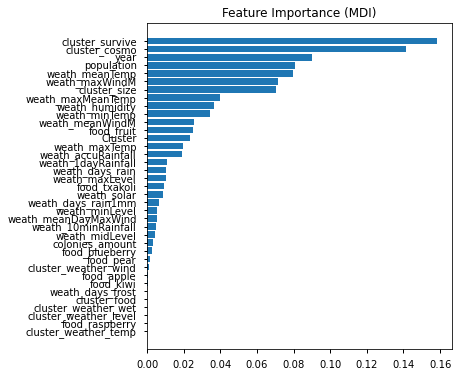

In [24]:
# get importance

feature_importance = model_fi.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

plt.show()

#### Now, do fit the model but only with the relevant features

In [25]:
#X_train = X_train.loc[:, ['population', 'weath_humidity', 'food_fruit', 'weath_maxLevel', 'food_txakoli', 'weath_midLevel', 'weath_minLevel', 'colonies_amount', 'weath_maxWindM',\
#                          'weath_meanWindM', 'weath_accuRainfall', 'weath_10minRainfall', 'food_kiwi', 'food_apple', 'weath_days_rain1mm', 'weath_meanDayMaxWind', 'weath_meanTemp']]

#X_predict = X_predict.loc[:, ['population', 'weath_humidity', 'food_fruit', 'weath_maxLevel', 'food_txakoli', 'weath_midLevel', 'weath_minLevel', 'colonies_amount', 'weath_maxWindM',\
#                              'weath_meanWindM', 'weath_accuRainfall', 'weath_10minRainfall', 'food_kiwi', 'food_apple', 'weath_days_rain1mm', 'weath_meanDayMaxWind', 'weath_meanTemp']]

In [26]:
X_train = X_train.loc[:, ['cluster_survive', 'cluster_cosmo', 'population', 'weath_meanTemp', 'cluster_size', 'weath_maxMeanTemp', 'weath_humidity', 'weath_minTemp', 'weath_meanWindM', 'food_fruit', 'Cluster', 'weath_maxTemp', 'weath_accuRainfall']]

X_predict = X_predict.loc[:, ['cluster_survive', 'cluster_cosmo', 'population', 'weath_meanTemp', 'cluster_size', 'weath_maxMeanTemp', 'weath_humidity', 'weath_minTemp', 'weath_meanWindM', 'food_fruit', 'Cluster', 'weath_maxTemp', 'weath_accuRainfall']]

In [27]:
reg.fit(X_train, y_train)

C:\Users\alebe\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor(learning_rate=0.03, loss='lad', max_depth=5,
                          n_estimators=500, random_state=23, subsample=0.7)

### 5. Predict the labels for new data

In [28]:
y_predict = reg.predict(X_predict)

In [29]:
y_predict.shape

(1344,)

In [30]:
QUEEN_predict['NESTS'] = y_predict

In [31]:
QUEEN_predict.NESTS.sum()

2276.8082732982252

In [32]:
QUEEN_predict.NESTS[QUEEN_predict.NESTS < 0] = 0

<ipython-input-32-ef4b3a26f94e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QUEEN_predict.NESTS[QUEEN_predict.NESTS < 0] = 0


In [33]:
QUEEN_predict.NESTS.sum()

2279.7472959013076

In [34]:
# export the dataset with the monthly data for viz purposes:

#QUEEN_predict.to_csv('WBds05_2020prediction_monthly.csv', index=False)

## Prepare the dataset for submission

In [35]:
HEX = QUEEN_predict.loc[:,['municip_code', 'municip_name', 'NESTS']].groupby(by=['municip_code', 'municip_name'], as_index=False).sum()

## Hard encode Bilbao 48020 to zero

In [36]:
HEX.loc[HEX.municip_code.isin([48020]), 'NESTS'] = 0

In [37]:
HEX.loc[HEX.municip_code.isin([48022, 48071, 48088, 48074, 48051, 48020]), :]

,municip_code,municip_name,NESTS
19,48020,Bilbao,0.000000
21,48022,Karrantza Harana/Valle de Carranza,11.565420
50,48051,Lanestosa,1.955425
70,48071,Muskiz,19.476095
73,48074,Urduña/Orduña,17.160172
87,48088,Ubide,2.201937


In [38]:
HEX.columns = ["CODIGO MUNICIPIO", "NOMBRE MUNICIPIO", "NIDOS 2020"] # change column names to Spanish (Competition template)

In [39]:
check_data(HEX)

Submission form Shape is (112, 3)
Number of Municipalities is 112
The Total 2020 Nests' Prediction is 2276


'All Municipality Names and Codes to be submitted match the Template'

## Hard encode municipalities 48022, 48071, 48088, 48074, and 48051

In [40]:
HEX.columns = ['municip_code', 'municip_name', 'NESTS'] # change column names to Spanish (Competition template)

In [41]:
HEX.loc[HEX.municip_code.isin([48022, 48071, 48088, 48074, 48051]), 'NESTS'] = [0,0,1,0,1]

In [42]:
HEX.loc[HEX.municip_code.isin([48022, 48071, 48088, 48074, 48051, 48020]), :]

,municip_code,municip_name,NESTS
19,48020,Bilbao,0.0
21,48022,Karrantza Harana/Valle de Carranza,0.0
50,48051,Lanestosa,0.0
70,48071,Muskiz,1.0
73,48074,Urduña/Orduña,0.0
87,48088,Ubide,1.0


In [43]:
HEX.columns = ["CODIGO MUNICIPIO", "NOMBRE MUNICIPIO", "NIDOS 2020"] # change column names to Spanish (Competition template)

In [44]:
check_data(HEX)

Submission form Shape is (112, 3)
Number of Municipalities is 112
The Total 2020 Nests' Prediction is 2225


'All Municipality Names and Codes to be submitted match the Template'

### Export dataset for submission

In [45]:
HEX.to_csv('WaspBusters_20210624_months_SKLearn48019prodigal.csv', index=False)